episode:   0 | score avg: 37.00 | memory length:   37 | epsilon: 1.0000
episode:   1 | score avg: 36.20 | memory length:   66 | epsilon: 1.0000
episode:   2 | score avg: 33.98 | memory length:   80 | epsilon: 1.0000
episode:   3 | score avg: 36.78 | memory length:  142 | epsilon: 1.0000
episode:   4 | score avg: 35.10 | memory length:  162 | epsilon: 1.0000
episode:   5 | score avg: 33.59 | memory length:  182 | epsilon: 1.0000
episode:   6 | score avg: 33.73 | memory length:  217 | epsilon: 1.0000
episode:   7 | score avg: 32.96 | memory length:  243 | epsilon: 1.0000
episode:   8 | score avg: 31.66 | memory length:  263 | epsilon: 1.0000
episode:   9 | score avg: 31.80 | memory length:  296 | epsilon: 1.0000
episode:  10 | score avg: 31.32 | memory length:  323 | epsilon: 1.0000
episode:  11 | score avg: 29.89 | memory length:  340 | epsilon: 1.0000
episode:  12 | score avg: 29.60 | memory length:  367 | epsilon: 1.0000
episode:  13 | score avg: 29.44 | memory length:  395 | epsilon:

episode:  94 | score avg: 181.67 | memory length: 2000 | epsilon: 0.0099
episode:  95 | score avg: 179.40 | memory length: 2000 | epsilon: 0.0099
episode:  96 | score avg: 178.46 | memory length: 2000 | epsilon: 0.0099
episode:  97 | score avg: 175.61 | memory length: 2000 | epsilon: 0.0099
episode:  98 | score avg: 172.65 | memory length: 2000 | epsilon: 0.0099
episode:  99 | score avg: 171.59 | memory length: 2000 | epsilon: 0.0099
episode: 100 | score avg: 170.63 | memory length: 2000 | epsilon: 0.0099
episode: 101 | score avg: 167.87 | memory length: 2000 | epsilon: 0.0099
episode: 102 | score avg: 165.78 | memory length: 2000 | epsilon: 0.0099
episode: 103 | score avg: 166.20 | memory length: 2000 | epsilon: 0.0099
episode: 104 | score avg: 164.18 | memory length: 2000 | epsilon: 0.0099
episode: 105 | score avg: 163.36 | memory length: 2000 | epsilon: 0.0099
episode: 106 | score avg: 163.33 | memory length: 2000 | epsilon: 0.0099
episode: 107 | score avg: 162.79 | memory length: 2

episode: 207 | score avg: 269.54 | memory length: 2000 | epsilon: 0.0099
episode: 208 | score avg: 274.99 | memory length: 2000 | epsilon: 0.0099
episode: 209 | score avg: 277.09 | memory length: 2000 | epsilon: 0.0099
episode: 210 | score avg: 273.98 | memory length: 2000 | epsilon: 0.0099
episode: 211 | score avg: 272.88 | memory length: 2000 | epsilon: 0.0099
episode: 212 | score avg: 266.00 | memory length: 2000 | epsilon: 0.0099
episode: 213 | score avg: 259.80 | memory length: 2000 | epsilon: 0.0099
episode: 214 | score avg: 257.52 | memory length: 2000 | epsilon: 0.0099
episode: 215 | score avg: 264.06 | memory length: 2000 | epsilon: 0.0099
episode: 216 | score avg: 258.06 | memory length: 2000 | epsilon: 0.0099
episode: 217 | score avg: 258.95 | memory length: 2000 | epsilon: 0.0099
episode: 218 | score avg: 266.26 | memory length: 2000 | epsilon: 0.0099
episode: 219 | score avg: 267.03 | memory length: 2000 | epsilon: 0.0099
episode: 220 | score avg: 263.83 | memory length: 2

SystemExit: 

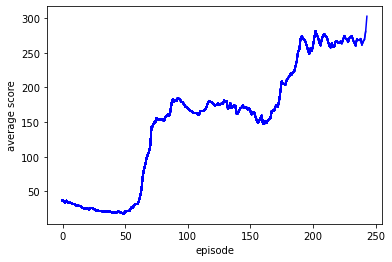

In [22]:
import os
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform

#상태가 입력, 큐함수가 출력인 인공신경망 생성
#클래스를 두번 호출해서 model,target_model을 생성
#하지만 무작위 수를 뽑아 가중치를 초기화 하기 때문에 통일해야 함,update_target_model()로 통일
class DQN(tf.keras.Model):
    def __init__(self,action_size):
        super(DQN,self).__init__()
        self.fc1= Dense(24,activation='relu')
        self.fc2= Dense(24,activation='relu')
        #action_size - 모델의 출력이 큐함수이므로 , 마지막 층의 크기는 행동의 개수가 되어야 함
        #RandomUniform 함수는 특정 범위 안에서 무작위 수를 뽑아 가중치를 초기화
        self.fc_out = Dense(action_size,
                           kernel_initializer = RandomUniform(-1e-3,1e-3))
    
    
    def call(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q
    
#카트폴 예제 DQN 

class DQNAgent:
    def __init__(self,state_size,action_size):
        self.render = False
        
        #상태와 행동 크기 정의
        
        self.state_size = state_size
        self.action_size = action_size
        
        #DQN 하이퍼파라미터
        
        self.discount_factor =0.99
        self.learning_rate = 0.001
        self.epsilon =1.0
        self.epsilon_decay =0.99
        self.epsilon_min =0.01
        self.batch_size = 64
        self.train_start =1000
        
        #리플레이 메모리 ,최대 크기
        self.memory= deque(maxlen=2000)
        
        #모델, 타깃모델 생성
        
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.optimizer = Adam(lr = self.learning_rate)
        
        #타깃 모델 초기화

        self.update_target_model()
        
    #타깃 모델을 모델의 가중치로 업데이트
    #model로 부터 가중치 값을 가져와 target_model의 가중치 값으로 설정
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        
    #입실론 탐욕 정책으로 행동 선택
    #입실론은 처음에는 1의 값을 가짐, 이때 agent는 무작위로 행동을 선택
    #매 step마다 입실론은 감소됨
    def get_action(self,state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        else:
            q_value = self.model(state)
            return np.argmax(q_value[0])
        
    #샘플 <s,a,r,s` > 을 리플레이 메모리에 저장
    
    def append_sample(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))
        
    #리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *=self.epsilon_decay
            
        #메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory,self.batch_size)
        
        states = np.array([sample[0][0] for sample in mini_batch])
        action = np.array([sample[1] for sample in mini_batch])
        reward = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])
        
        #학습 파라미터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            
            #현재 상태에 대한 모델의 큐함수
            predicts = self.model(states)
            #실제로 한 행동이 1이고 나머지는 0인 원핫벡터를 사용
            one_hot_action = tf.one_hot(action,self.action_size)
            predicts = tf.reduce_sum(one_hot_action*predicts,axis=1)
           
        
            #업데이트 target을 안정시키기 위해서
            #다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_states)
            #학습 도중 타깃 모델이 학습되는 일이 없게 tf.stop_gradient 적용
            target_predicts = tf.stop_gradient(target_predicts)
            
            #벨만 최적 방정식을 이용한 업데이트 타깃
            #큐함수 중 가장 큰 값
            max_q = np.amax(target_predicts,axis=-1)
            targets = reward + (1 - dones) * self.discount_factor *max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))
        
        #오류함수를 줄이는 방향으로 모델 업데이트
        #업데이트하는 것은 타깃모델 x 현재모델임
        grads =tape.gradient(loss,model_params)
        self.optimizer.apply_gradients(zip(grads,model_params))

        
if __name__ == "__main__":
    # CartPole-v1 환경, 최대 타임스텝 수가 500
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # DQN 에이전트 생성
    '''
    1. state에 따른 action 선택
    2. 선택한 action으로 environment에서 한 step 진행
    3. environment로 부터 reward와 다음 state를 받음
    4. sample을 리플레이에 저장
    5.리플레이 메모리에서 무작위 추출한 sample로 학습
    6.에피소드 마다 타깃 모델 업데이트    
    
    '''
    agent = DQNAgent(state_size, action_size)
    
    

    scores, episodes = [], []
    score_avg = 0

    num_episode = 300
    for e in range(num_episode):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            #(4,) 에서 (1,4)로 모양 변경
            
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # 타임스텝마다 보상 0.1, 에피소드가 중간에 끝나면 -1 보상
            score += reward
            reward = 0.1 if not done or score == 500 else -1

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()
                # 에피소드마다 학습 결과 출력
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(
                      e, score_avg, len(agent.memory), agent.epsilon))

                # 에피소드마다 학습 결과 그래프로 저장
                scores.append(score_avg)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                #가로 에피소드
                pylab.xlabel("episode")
                #세로 에피소드가 지속된 시간의 이동평균
                pylab.ylabel("average score")
                pylab.savefig("./save_graph/graph.png")

                # 이동 평균이 400 이상일 때 종료
                if score_avg > 300:
                    agent.model.save_weights("./save_model/model", save_format="tf")
                    sys.exit()        
